In [20]:
import pandas as pd
import numpy as np
import os
import tensorflow as tf
import cv2
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Input, InputLayer, Flatten, BatchNormalization, Dropout
from tensorflow.keras.models import Sequential, Model
from  matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
import matplotlib.image as mpimg
%matplotlib inline

In [21]:
tf.__version__

'2.4.1'

<p style="font-size:20px;">
<b>
covid 299*299
<br>
fibrosis 1024*1024
<br>
pneumonia x*y
<br>
tb 512*512
<br>
normal x*y
</b>
</p>

In [22]:
IMG_HEIGHT = 299
IMG_WIDTH = 299

In [23]:
!rm -r ./* && mkdir Data && cd Data && mkdir train test val
!cd ./Data/train && mkdir Normal PNEUMONIA COVID Fibrosis Tuberculosis
!cd ./Data/test && mkdir Normal PNEUMONIA COVID Fibrosis Tuberculosis
!cd ./Data/val && mkdir Normal PNEUMONIA COVID Fibrosis Tuberculosis

In [24]:
def create_dataset(img_folder):
    #img_data_array=[]
    #class_name=[]
    i = 1
    for dir1 in os.listdir(img_folder):
        for file in os.listdir(os.path.join(img_folder, dir1)):
            image_path= os.path.join(img_folder, dir1,  file)
            image= cv2.imread( image_path, cv2.COLOR_BGR2RGB)
            image=cv2.resize(image, (IMG_HEIGHT, IMG_WIDTH),interpolation = cv2.INTER_AREA)
            image=np.array(image)
#             image = image.astype('float32')
#             image /= 255 
            #img_data_array.append(image)
            #class_name.append(dir1)
#             print(file, dir1)
#             break
            if i < 71:
                cv2.imwrite("./Data/train/" +dir1+"/"+file, image)
            elif i < 86:
                cv2.imwrite("./Data/test/" +dir1+"/"+file, image)
            else:
                cv2.imwrite("./Data/val/" +dir1+"/"+file, image)
            i += 1
            if i == 101:
                i = 1
        
# extract the image array and class name
# img_data, class_name = create_dataset(r'../input/covid19-detection/Data')
create_dataset(r'../input/covid19-detection/Data')

In [25]:
!ls ./Data/train/Normal | wc -l

8227


Populating the interactive namespace from numpy and matplotlib


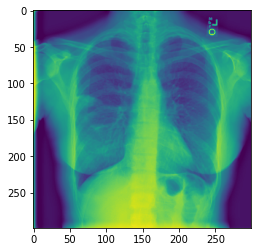

In [26]:
%pylab inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img = mpimg.imread('./Data/val/Fibrosis/00011238_000.png')
imgplot = plt.imshow(img)
plt.show()

In [27]:
batch_size = 64
img_height = 299
img_width = 299
data_dir = "./Data/train"
data_dir1 = "./Data/val"

In [28]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=None,
  shuffle=True,
  image_size=(img_height, img_width),
  subset=None,
  seed=123,
  batch_size=batch_size,
  label_mode='categorical'
)

Found 17394 files belonging to 5 classes.


In [29]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir1,
  validation_split=None,
  shuffle=True,
  image_size=(img_height, img_width),
  subset=None,
  seed=123,
  batch_size=batch_size,
  label_mode='categorical'
)

Found 3720 files belonging to 5 classes.


In [30]:
class_names = train_ds.class_names
print(class_names)

['COVID', 'Fibrosis', 'Normal', 'PNEUMONIA', 'Tuberculosis']


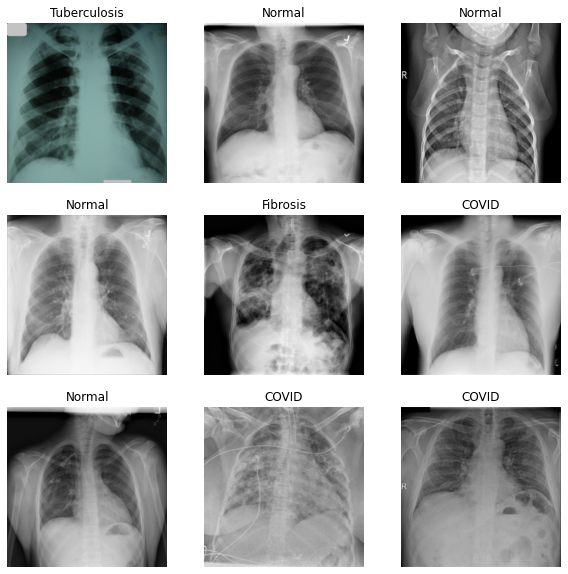

In [31]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[np.where(labels[i].numpy() == 1)[0][0]])
#         print()
        plt.axis("off")

In [32]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(64, 299, 299, 3)
(64, 5)


In [33]:
model = tf.keras.applications.InceptionV3(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=(img_height,img_width, 3),
    classes=5
)

In [34]:
# model.summary()

In [35]:
fm = Sequential()
fm.add(model)
fm.add(Flatten())
# fm.add(Dense(128, activation='relu'))
# fm.add(Dropout(0.2))
fm.add(Dense(5, activation='softmax'))

In [36]:
fm.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 8, 8, 2048)        21802784  
_________________________________________________________________
flatten_1 (Flatten)          (None, 131072)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 655365    
Total params: 22,458,149
Trainable params: 22,423,717
Non-trainable params: 34,432
_________________________________________________________________


In [37]:
fm.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [38]:
history = fm.fit(train_ds, batch_size=batch_size, epochs=25, verbose=1, validation_data=val_ds)

Epoch 1/25
272/272 [==============================] - 212s 747ms/step - loss: 2.0819 - accuracy: 0.6429 - val_loss: 1.8470 - val_accuracy: 0.6798
Epoch 2/25
272/272 [==============================] - 200s 728ms/step - loss: 0.3172 - accuracy: 0.8918 - val_loss: 22140.5332 - val_accuracy: 0.1707
Epoch 3/25
272/272 [==============================] - 200s 730ms/step - loss: 0.6343 - accuracy: 0.8050 - val_loss: 0.6843 - val_accuracy: 0.7962
Epoch 4/25
272/272 [==============================] - 199s 728ms/step - loss: 0.2637 - accuracy: 0.9029 - val_loss: 0.2760 - val_accuracy: 0.8927
Epoch 5/25
272/272 [==============================] - 197s 721ms/step - loss: 0.1783 - accuracy: 0.9356 - val_loss: 1.8012 - val_accuracy: 0.6019
Epoch 6/25
272/272 [==============================] - 196s 717ms/step - loss: 0.2735 - accuracy: 0.9171 - val_loss: 1.6316 - val_accuracy: 0.7099
Epoch 7/25
272/272 [==============================] - 195s 715ms/step - loss: 0.8235 - accuracy: 0.8175 - val_loss: 1.68

<AxesSubplot:>

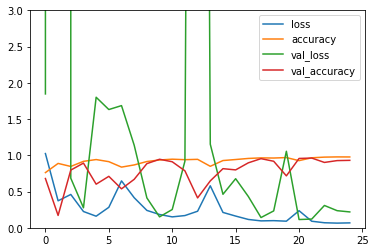

In [48]:
pd.DataFrame(history.history).plot(ylim=(0, 3))

In [49]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
  "./Data/test",
  validation_split=None,
  shuffle=True,
  image_size=(img_height, img_width),
  subset=None,
  seed=123,
  batch_size=batch_size,
  label_mode='categorical'
)

Found 3720 files belonging to 5 classes.


In [105]:
test_accu = fm.evaluate(test_ds)
print('The testing accuracy is :',test_accu[1]*100, '%')

59/59 [==============================] - 19s 308ms/step - loss: 0.2490 - accuracy: 0.9272
The testing accuracy is : 92.7150547504425 %


In [53]:
test_accu

[0.24899394810199738, 0.927150547504425]

In [60]:
preds = fm.predict(test_ds,verbose=1)

59/59 [==============================] - 19s 303ms/step


In [61]:
pd = preds.copy()

In [64]:
preds = pd.copy()
preds = [int(max(x)*5) for x in preds]
# preds

In [69]:
true_categories = tf.concat([y for x, y in test_ds], axis=0)


In [76]:
preds = []
for v in pd:
    x = []
    i = max(v)
    for val in v:
        if val == i:
            x.append(1)
        else:
            x.append(0)
    preds.append(x)

In [78]:
preds[0]

[0, 0, 1, 0, 0]

In [91]:
print(true_categories.numpy())
print(type(true_categories.numpy().tolist()), type(preds))

[[0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0.]
 ...
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0.]]
<class 'list'> <class 'list'>


In [95]:
import pandas as pds

In [98]:
# y_pred=model.predict(X_test) 
confusion_matrix(true_categories.numpy().argmax(axis=1), np.array(preds).argmax(axis=1))

array([[ 80,  30, 280,  90,  60],
       [ 41,  14, 120,  47,  33],
       [280,  77, 891, 302, 220],
       [100,  35, 299, 115,  81],
       [ 78,  29, 256,  89,  73]])

In [99]:
# print(true_categories, preds, pd)

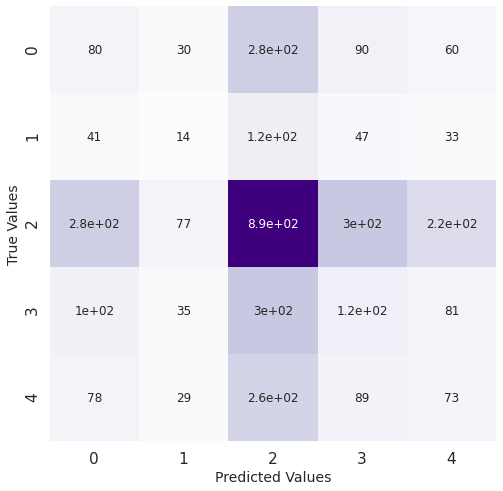

In [102]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(true_categories.numpy().argmax(axis=1), np.array(preds).argmax(axis=1))
fig = plt.figure(figsize = (8,8))
ax1 = fig.add_subplot(1,1,1)
sns.set(font_scale=1.4) #for label size
sns.heatmap(cm, annot=True, annot_kws={"size": 12},
     cbar = False, cmap='Purples');
ax1.set_ylabel('True Values',fontsize=14)
ax1.set_xlabel('Predicted Values',fontsize=14)
plt.show()

In [104]:
 print(classification_report(true_categories.numpy().argmax(axis=1), np.array(preds).argmax(axis=1)))

              precision    recall  f1-score   support

           0       0.14      0.15      0.14       540
           1       0.08      0.05      0.06       255
           2       0.48      0.50      0.49      1770
           3       0.18      0.18      0.18       630
           4       0.16      0.14      0.15       525

    accuracy                           0.32      3720
   macro avg       0.21      0.21      0.21      3720
weighted avg       0.31      0.32      0.31      3720



In [ ]:
# import tensorflow as tf
# tf.test.gpu_device_name()

In [ ]:
# !pip install tensorflow-gpu

In [ ]:
# Results

# 1. resnet50 gave bad results, around 60%
# 2. inceptionv3 gave around 95% result(on original dataset, direclty read from input folder)
# 